# 2D CFD Simulations #

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Steady State Heat Diffusion in Square Plate

- Governing Equation: ∂²T/∂x² + ∂²T/∂y² = ∇²T = 0
- Boundary Condition: T(x=0) = 100, T(y=0) = T(y=100) = T(x=100) = 0

- Discretized: T(i,j) = ( T(i-1,j-1) + T(i+1,j-1) + T(i-1,j+1) + T(i+1,j+1) ) / 4

- Can use a simple 5-point Iterative Stencil Loop due to local PDE discretization
- Convergence is achieved with increasing iterations

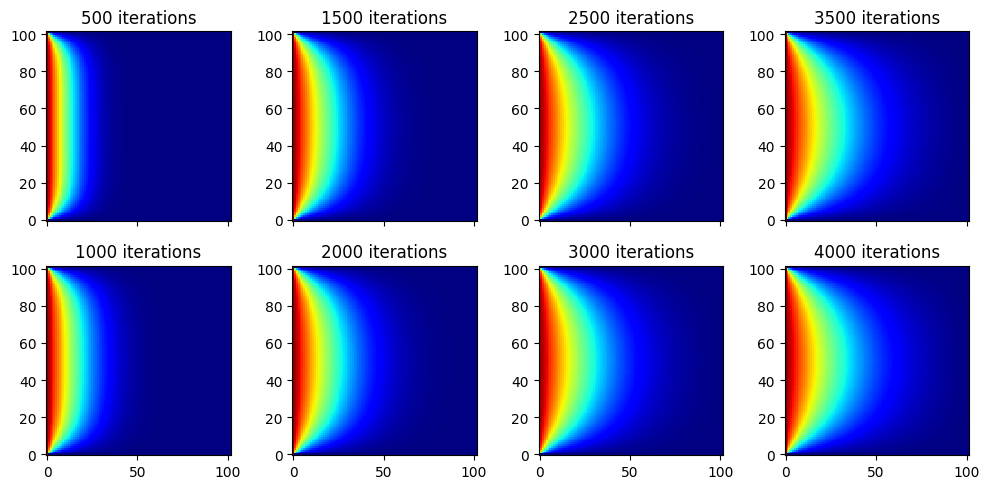

In [136]:
# grid size
x_size = 100
y_size = 100

# Note: index 0 and -1 are outside edges 
T = np.zeros((y_size+2, x_size+2))
T[1:x_size+1, 0] = 100

# define plots
fig, ax = plt.subplots(2, 4, sharex=True, figsize=(10, 5))

# iteration to convergence, with intermediate plotting every 800 iterations
for i in range(8):

    for j in range(500):
        # Tn stores values from previous iteration, used to obtain new T
        Tn = T.copy()   

        # 5-point stencil method (2D) - only for special cases of local PDE discretizations
        T[1:-1, 1:-1] = (Tn[0:-2, 1:-1] + Tn[2:, 1:-1] + Tn[1:-1, 0:-2] + Tn[1:-1, 2:]) / 4

        T[0, :] = 0
        T[-1, :] = 0
        T[:, 0] = 100
        T[:, -1] = 0
        
    axi = ax[i%2][i//2]
    axi.set_title(f"{(i+1)*500} iterations")
    axi.pcolormesh(range(x_size+2), range(y_size+2), T, cmap="jet")

fig.tight_layout()  # ensures title and subplots are properly spaced with no overlaps
plt.show() # shows progressively converging temperature distribution in the plate


## Nonlinear Convection ##

- Governing Equations: 
    - ∂u/∂t + u(∂u/∂x) + v(∂u/∂y) = 0
    - ∂v/∂t + u(∂v/∂x) + v(∂v/∂y) = 0
- Discretized Equations:
    - ( u(i,j,n+1) - u(i,j,n) ) / dt + u(i,j,n) ( u(i,j,n) - u(i-1,j,n) ) / dx + v(i,j,n) ( u(i,j,n) - u(i,j-1,n) ) / dy = 0
    - ( v(i,j,n+1) - v(i,j,n) ) / dt + u(i,j,n) ( v(i,j,n) - v(i-1,j,n) ) / dx + v(i,j,n) ( v(i,j,n) - v(i,j-1,n) ) / dy = 0
    - can express unknown (n+1)th time u(i,j,n+1) and v(i,j,n+1) as function of known nth time u and v
- Initial Conditions: 
    - u, v = 2 for x,y ∈ (0.5,1)×(0.5,1)
    - u, v = 1 everywhere else
- Boundary Conditions:
    - u, v = 1 for x=0,2, y=0,2
- Reference: https://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/

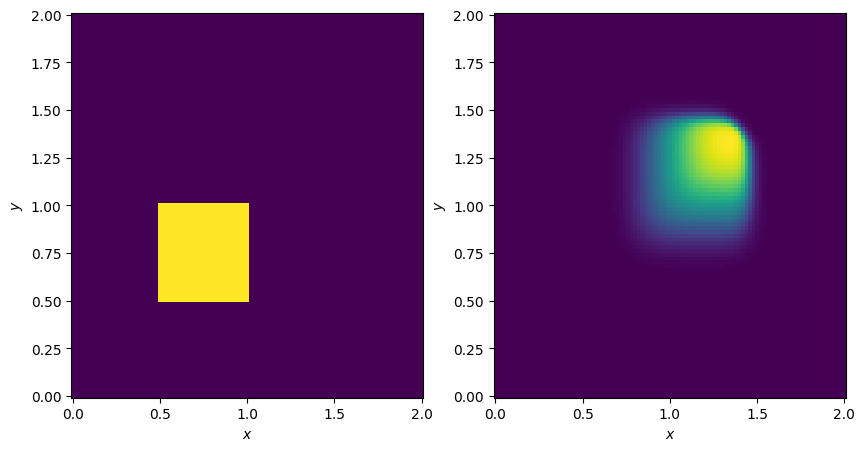

In [137]:
# grid size
x_size = 2
y_size = 2

# number of grid points
nx = 101
ny = 101
nt = 80

# step size
dx = x_size / (nx - 1)
dy = y_size / (ny - 1)
sigma = 0.2
dt = sigma * dx

# grid velocity values setup
u = np.ones((nx, ny))   # current u velocity (n+1)
v = np.ones((nx, ny))   # current v velocity (n+1)

# initial conditions (square hat function)
u[int(0.5/dy) : int(1/dy+1), int(0.5/dx) : int(1/dx+1)] = 2
v[int(0.5/dy) : int(1/dy+1), int(0.5/dx) : int(1/dx+1)] = 2

# setup figure meshgrid and axes
fig, (ax_initial, ax_final)= plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)
ax = fig.gca()
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

# plot initial
ax_initial.pcolormesh(X, Y, u, cmap=cm.viridis)
ax_initial.set_xlabel('$x$')
ax_initial.set_ylabel('$y$')

# time advancement - stencil method
for i in range(nt):
    un = u.copy()
    vn = v.copy()
    u[1:-1, 1:-1] = un[1:-1, 1:-1] \
                    - (dt/dx)*un[1:-1, 1:-1]*(un[1:-1, 1:-1] - un[1:-1, 0:-2]) \
                    - (dt/dy)*vn[1:-1, 1:-1]*(un[1:-1, 1:-1] - un[0:-2, 1:-1])
    v[1:-1, 1:-1] = vn[1:-1, 1:-1] \
                    - (dt/dx)*un[1:-1, 1:-1]*(vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) \
                    - (dt/dy)*vn[1:-1, 1:-1]*(vn[1:-1, 1:-1] - vn[0:-2, 1:-1])

# plot final
ax_final.pcolormesh(X, Y, u, cmap=cm.viridis)
ax_final.set_xlabel('$x$')
ax_final.set_ylabel('$y$')
plt.show()

Alternatively, using matrix assembly approach
- see matrix_assy.py and linear_solvers.py (in progress)

## Lid-Driven Cavity Flow (momentum-pressure formulation) ##
- Governing Equations (NS equations with no gravity): 
    - ∂u/∂t + u(∂u/∂x) + v(∂u/∂y) = -(1/ρ)(∂P/∂x) + 𝜈(∂²u/∂x² + ∂²u/∂y²)
    - ∂v/∂t + u(∂v/∂x) + v(∂v/∂y) = -(1/ρ)(∂P/∂y) + 𝜈(∂²v/∂x² + ∂²v/∂y²)
- Discretized Equations:
    - (see code)
- Initial Conditions:
    - u, v, p = 0 everywhere
- Boundary Conditions:
    - u, v = 0  at x=0, y=0, y=2 (walls)
    - u = 1     at y=2 (lid)
    - P = 0     at y=2 (lid)
    - ∂P/∂x = 0 at x=0, x=2
    - ∂P/∂y = 0 at y=0

Note: Both a velocity and pressure field are required to evolve the coupled momentum (navier stokes) and pressure (poisson) equations.
Continuity Equation is implicitly enforced though computation of the pressure field, since its derivation involves the use of incompressible continuity equation (derivation is done through taking the divergence of the momentum equation).

In [138]:
# pressure correction at one time step, formulation enforces continuity at next velocity time step
def pressure_poisson(rho: float, p: np.ndarray, u: np.ndarray, v: np.ndarray, 
                     dx: float, dy: float, dt: float, n_iter: int) -> np.ndarray :
    
    # iterate the pressure poisson equation until convergence at one time step
    for _ in range(n_iter):

        # set pn as old pressure field
        pn = p.copy()

        # update pressure field 
        p[1:-1, 1:-1] = 1 / ( 2*(dx**2 + dy**2) ) * ( 
                        - (rho/dt) * (u[1:-1, 2:] - u[1:-1, :-2]) / (2*dx) *dx**2 * dy**2
                        - (rho/dt) * (v[2:, 1:-1] - v[:-2, 1:-1]) / (2*dy) *dx**2 * dy**2
                        + (pn[1:-1, :-2] + pn[1:-1, 2:])*dy**2 
                        + (pn[:-2, 1:-1] + pn[2:, 1:-1])*dx**2 
                        - rho * (u[1:-1, 2:] - u[1:-1, :-2])**2 * dy**2 / 4
                        - rho * (v[2:, 1:-1] - v[:-2, 1:-1])**2 * dx**2 / 4
                        - rho * (u[2:, 1:-1] - u[:-2, 1:-1])*(v[1:-1, 2:] - v[1:-1, :-2]) * dx * dy / 4
                        )

        # enforce boundary conditions on outer grid layer
        p[:, 0] = p[:, 1]   # dp/dx=0 at x=0
        p[:, -1] = p[:, -2] # dp/dx=0 at x=2
        p[0, :] = p[1, :]   # dp/dy=0 at y=0
        p[-1, :] = 0        # p=0 at y=2

        # note that the B.C.s are applied such that the wall pressure changes based on the adjacent grid values
        # this allows dp/dx and dp/dy to be zero where needed, but allows p to adjust along the walls

    return p

In [253]:
# main function that solves the flow
def cavity_flow(rho: float, nu: float, U: float,
                u: np.ndarray, v: np.ndarray, p: np.ndarray, 
                dx: float, dy: float, dt: float, nt: int, n_iter: int):
    
    # global time advancement loop
    for _ in range(nt):

        # set un and vn as previous time step
        un = u.copy()
        vn = v.copy()

        # compute the pressure, corrected to enforce continuity
        p = pressure_poisson(rho, p, u, v, dx, dy, dt, n_iter)

        # update u and v via discretised Navier-Stokes 
        u[1:-1, 1:-1] = un[1:-1, 1:-1] \
                        - dt/dx * un[1:-1, 1:-1] * (un[1:-1, 2:] - un[1:-1, :-2])/2 \
                        - dt/dy * vn[1:-1, 1:-1] * (un[2:, 1:-1] - un[:-2, 1:-1])/2 \
                        - dt/(2*rho*dx) * (p[1:-1, 2:] - p[1:-1, :-2]) \
                        + dt*nu/dx**2 * (un[1:-1, 2:] - 2*un[1:-1, 1:-1] + un[1:-1, :-2]) \
                        + dt*nu/dy**2 * (un[2:, 1:-1] - 2*un[1:-1, 1:-1] + un[:-2, 1:-1])
        
        v[1:-1, 1:-1] = vn[1:-1, 1:-1] \
                        - dt/dx * un[1:-1, 1:-1] * (vn[1:-1, 2:] - vn[1:-1, :-2])/2 \
                        - dt/dy * vn[1:-1, 1:-1] * (vn[2:, 1:-1] - vn[:-2, 1:-1])/2 \
                        - dt/(2*rho*dy) * (p[2:, 1:-1] - p[:-2, 1:-1]) \
                        + dt*nu/dx**2 * (vn[1:-1, 2:] - 2*vn[1:-1, 1:-1] + vn[1:-1, :-2]) \
                        + dt*nu/dy**2 * (vn[2:, 1:-1] - 2*vn[1:-1, 1:-1] + vn[:-2, 1:-1])

        # enforce boundary conditions
        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = U
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0 

    return u, v, p

In [266]:
# grid size
x_size = 2
y_size = 2

# number of grid points
nx = 82         # index 0 and 81 are outer boundaries, determined by B.C.s
ny = 82         # index 0 and 81 are outer boundaries, determined by B.C.s
nt = 2000       # time advancement steps
n_iter = 50     # sub-iteration count to converge pressure field

# step size
dx = x_size / (nx - 2)
dy = y_size / (ny - 2)
dt = .001

# physical variables
rho = 1
nu = .1
U = 5       # lid u-velocity

# grid initial values setup
u = np.zeros((ny, nx))   # current u velocity (n+1)
v = np.zeros((ny, nx))   # current v velocity (n+1)
p = np.zeros((ny, nx))   # next pressure field
'''b = np.zeros((ny, nx))   # intermediate velocity can be used to simplify pressure correction function'''
u[-1, :] = U

# main function call that time steps and computes final fields
u, v, p = cavity_flow(rho, nu, U, u, v, p, dx, dy, dt, nt, n_iter)

# NOTE: once nx and ny exceed about 100, instability arises around nt=500

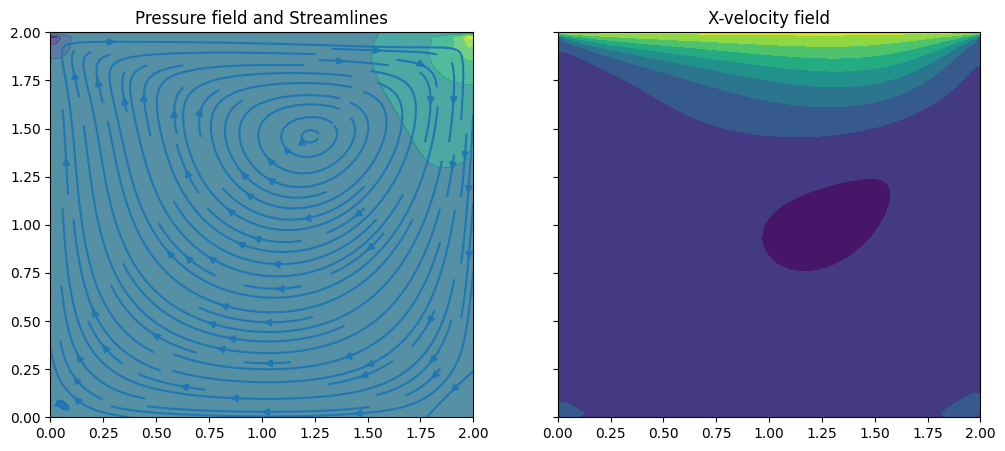

In [267]:
# plot setup
x = np.linspace(0, x_size, nx)
y = np.linspace(0, y_size, ny)
X, Y = np.meshgrid(x, y)

# plotting fields
fig, (axp, axu) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=100, sharey=True)

axp.contourf(X, Y, p, cmap='viridis', alpha=0.8) # alternatively use plt.pcolormesh()
axp.streamplot(X, Y, u, v, density=1.2)
axp.set_title('Pressure field and Streamlines')

axu.contourf(X, Y, u, cmap='viridis')
axu.set_title('X-velocity field')

plt.xlim(0, 2)
plt.ylim(0, 2)
plt.show()

Note that this FD scheme and projection method are highly unstable methods that are not robust. Slightly changing certain values causes the results to possibly blow up, become unstable, show unsteady effects, deviating from the validated results. The particular example shown is chosen to be a case where it happens to align well for validation. 

Possible areas to consider to further improvement of the solver:
- other forms of equations (e.g. skew-symmetric form, streamfunction-vorticity)
- upwind scheme (spatial discretization)
- implicit scheme (time integration)
- CFL number restriction
- Re_grid restriction
- implement a scaling rule to ensure the above 2 are enforced

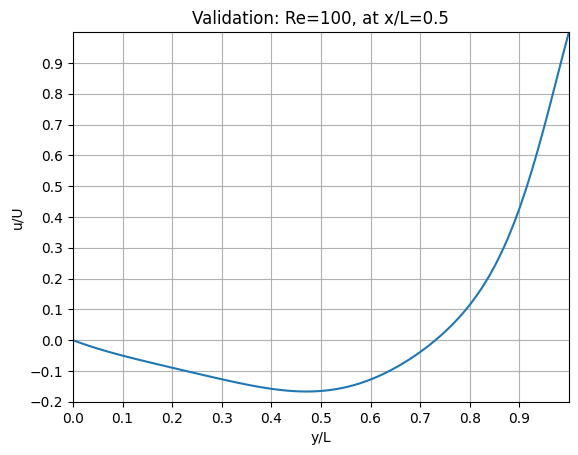

In [ ]:
# validation of results, refer to published results for comparison

# take vertical mid-line u-velocity data, i.e. x/L=0.5
u_mid = u[:, nx//2]

# plot u/U against y/L
plt.plot(np.linspace(0, 1, len(u_mid)), u_mid/U)
plt.xlim(0, 1)
plt.ylim(-0.2, 1)
plt.xlabel('y/L')
plt.ylabel('u/U')
plt.title('Validation: Re=100, at x/L=0.5')
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(-0.2, 1, 0.1))
plt.grid()
plt.show()

## Lid-Driven Cavity Flow (Streamfunction-Vorticity formulation) ##